Setting up Enviromnment

In [1]:
import warnings
warnings.filterwarnings("ignore")

Import necessary packages

In [2]:
# import Libraries
from salesforcecdpconnector.connection import SalesforceCDPConnection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import os
import joblib
from google.cloud import storage

Create folders to store model artifacts and preprocessing files

In [3]:
model_artifact_dir_name = "model_artifacts"
preprocess_dir_name = "src_dir"

if not os.path.exists(model_artifact_dir_name):
    os.mkdir(model_artifact_dir_name)
    print(f"Directory '{model_artifact_dir_name}' created.")
else:
    print(f"Directory '{model_artifact_dir_name}' already exists.")
    
if not os.path.exists(preprocess_dir_name ):
    os.mkdir(preprocess_dir_name )
    print(f"Directory '{preprocess_dir_name }' created.")
else:
    print(f"Directory '{preprocess_dir_name }' already exists.")    

Directory 'model_artifacts' already exists.
Directory 'src_dir' already exists.


Get Secret Details

In [4]:
from google.cloud import secretmanager

# Replace with your secret name

'''
secret_name = "projects/<your project id>/secrets/<your secret name>/versions/latest"

'''
# Put your secret's details in the line below
secret_name = "projects/yourprojectid/secrets/yoursecretname/versions/latest"

# Initialize the client
client = secretmanager.SecretManagerServiceClient()

# Access the secret version
response = client.access_secret_version(name=secret_name)

# Extract the secret payload (JSON)
secret_payload = response.payload.data.decode("UTF-8")

# Parse the JSON
import json

secret_data = json.loads(secret_payload)

# Access individual elements
login_url = secret_data["login_url"]
userid = secret_data["userid"]
password = secret_data["password"]
client_id = secret_data["client_id"]
client_secret = secret_data["client_secret"]

Set up CDP Connector

In [5]:
conn = SalesforceCDPConnection(
        login_url, 
        userid, 
        password,  
        client_id,
        client_secret
    )

print(conn)

Query training data from CDP into dataframe

In [6]:
# Update the name of the DLO or DMO that you want to query
query = "SELECT product_purchased__c, club_member__c, campaign__c, state__c, month__c, case_count__c, case_type_return__c, case_type_shipment_damaged__c, pages_visited__c,engagement_score__c, tenure__c, clicks__c FROM Recommendation_Data__dll limit 10000"

df = conn.get_pandas_dataframe(query)
print("Fetched")

Fetched


Exploratory Analysis

In [7]:
# Print number of rows and columns of the dataframe
df.shape

(10000, 12)

In [8]:
# Summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_purchased__c           10000 non-null  object 
 1   club_member__c                 10000 non-null  float64
 2   campaign__c                    10000 non-null  object 
 3   state__c                       10000 non-null  object 
 4   month__c                       10000 non-null  float64
 5   case_count__c                  10000 non-null  float64
 6   case_type_return__c            10000 non-null  float64
 7   case_type_shipment_damaged__c  10000 non-null  float64
 8   pages_visited__c               10000 non-null  float64
 9   engagement_score__c            10000 non-null  float64
 10  tenure__c                      10000 non-null  float64
 11  clicks__c                      10000 non-null  float64
dtypes: float64(9), object(3)
memory usage: 937.6+ K

In [9]:
# View numerical predictors statistics
df.describe()

,club_member__c,month__c,case_count__c,case_type_return__c,case_type_shipment_damaged__c,pages_visited__c,engagement_score__c,tenure__c,clicks__c
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.303100,7.73300,0.597900,0.103900,0.04950,15.860700,53.626500,2.011700,25.954900
std,0.459621,3.24998,1.129931,0.305146,0.21692,3.165296,3.534522,1.016694,6.143683
min,0.000000,1.00000,0.000000,0.000000,0.00000,8.000000,44.000000,0.000000,13.000000
25%,0.000000,5.00000,0.000000,0.000000,0.00000,14.000000,51.000000,1.000000,21.000000
50%,0.000000,8.00000,0.000000,0.000000,0.00000,15.000000,53.000000,2.000000,25.000000
75%,1.000000,11.00000,1.000000,0.000000,0.00000,18.000000,56.000000,3.000000,30.000000
max,1.000000,12.00000,7.000000,1.000000,1.00000,32.000000,69.000000,6.000000,61.000000


In [10]:
# Preview data
df.head()

,product_purchased__c,club_member__c,campaign__c,state__c,month__c,case_count__c,case_type_return__c,case_type_shipment_damaged__c,pages_visited__c,engagement_score__c,tenure__c,clicks__c
0,Paramount Peak Convertible Pants,1.0,Webinar,New York,10.0,0.0,0.0,0.0,23.0,50.0,4.0,24.0
1,Angstom 20 Backpack,1.0,Webinar,Massachusetts,9.0,0.0,1.0,0.0,20.0,53.0,3.0,22.0
2,Womens Alpine Project Jacket,0.0,New Colors,Massachusetts,1.0,2.0,0.0,0.0,12.0,53.0,3.0,36.0
3,Womens ARCTIC PARKA,0.0,Webinar,Washington,12.0,2.0,0.0,0.0,18.0,51.0,3.0,35.0
4,Womens Alpine Project Jacket,1.0,Webinar,Massachusetts,12.0,2.0,0.0,0.0,15.0,54.0,1.0,31.0


In [11]:
# Check for missing Values
df.isna().sum()

product_purchased__c             0
club_member__c                   0
campaign__c                      0
state__c                         0
month__c                         0
case_count__c                    0
case_type_return__c              0
case_type_shipment_damaged__c    0
pages_visited__c                 0
engagement_score__c              0
tenure__c                        0
clicks__c                        0
dtype: int64

In [12]:
# Function to create descriptive statistics of categorical variables

def describe_categorical(t):
    uniquecategories = len(list(t.unique()))
    print("Number of Unique Categories : " + str(uniquecategories))
    tmp = pd.DataFrame()
    tmp = t.value_counts().reset_index(name='counts').rename({'index': 'Categories'}, axis=1)
    tmp['%'] = 100 * tmp['counts'] / tmp['counts'].sum()
    print(tmp)
    tmp['percentages'] = tmp['%'].apply(lambda x: '{:.2f}%'.format(x))
    tmp.sort_values(by = '%', inplace = True, ascending = False)
    ax = tmp.plot(x="Categories", y=["counts"], kind="bar")  
    for i, val in enumerate(tmp['counts']):
        ax.text(i, val, tmp['percentages'][i], horizontalalignment='center')

In [13]:
# Function to create descriptive statistics of continous variables

def describe_continuous(t):
    t.describe()
    fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
    ax[0].set_title("Distribution Plot")
    #sns.histplot(t,ax=ax[0])
    sns.kdeplot(t,fill=True, ax=ax[0])
    ax[1].set_title("Violin Plot")
    sns.violinplot(y=t,ax=ax[1], inner="quartile")
    ax[2].set_title("Box Plot")
    sns.boxplot(y=t,ax=ax[2],orient='v')  

Number of Unique Categories : 11
                          Categories  counts      %
0   Paramount Peak Convertible Pants    2502  25.02
1       Womens Alpine Project Jacket    1503  15.03
2               Womens Cypress Capri    1209  12.09
3                  Mens Agiity Pants    1050  10.50
4                Womens ARCTIC PARKA     981   9.81
5            Mens Apex Bionic Jacket     956   9.56
6                 Mens Agiity Shorts     601   6.01
7         Mens Hedgehog GTX XCR Shoe     599   5.99
8                Angstom 20 Backpack     407   4.07
9               Womens Montana Glove     175   1.75
10                                        17   0.17


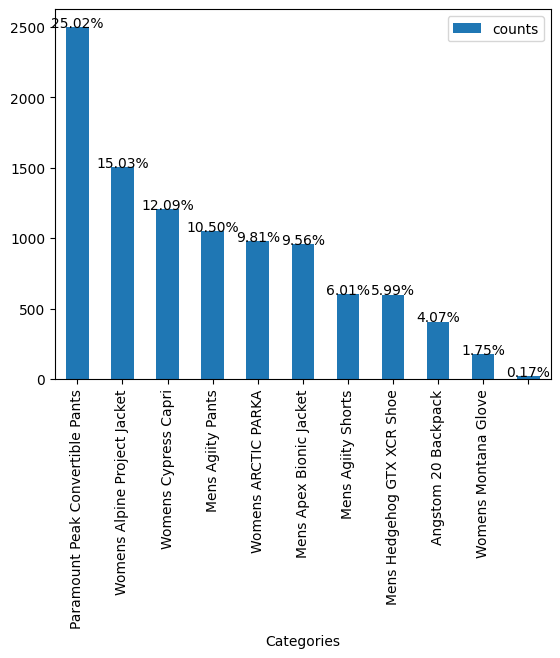

In [14]:
describe_categorical(df['product_purchased__c']) 

Number of Unique Categories : 3
       Categories  counts      %
0         Webinar    5013  50.13
1      New Colors    3014  30.14
2  Year-in Review    1973  19.73


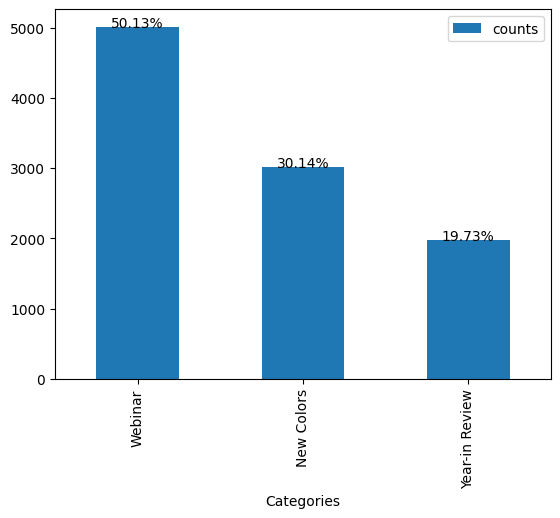

In [15]:
describe_categorical(df['campaign__c']) 

Number of Unique Categories : 2
   Categories  counts      %
0         0.0    6969  69.69
1         1.0    3031  30.31


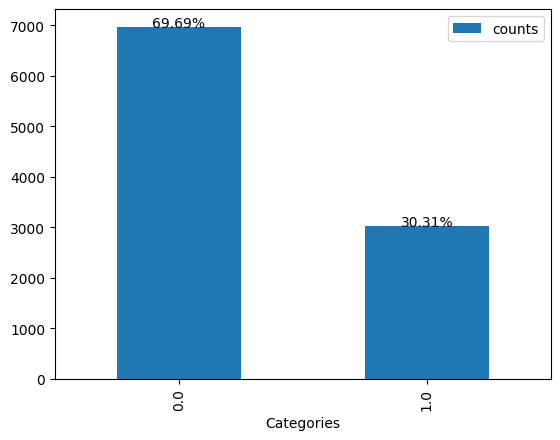

In [16]:
describe_categorical(df['club_member__c']) 

Number of Unique Categories : 13
       Categories  counts      %
0      Washington    1997  19.97
1   Massachusetts    1954  19.54
2       Minnesota    1041  10.41
3        Colorado    1024  10.24
4         Arizona    1021  10.21
5      California     988   9.88
6         Vermont     960   9.60
7          Oregon     325   3.25
8        New York     299   2.99
9           Maine     179   1.79
10    Connecticut     103   1.03
11  New Hampshire      66   0.66
12     New Jersey      43   0.43


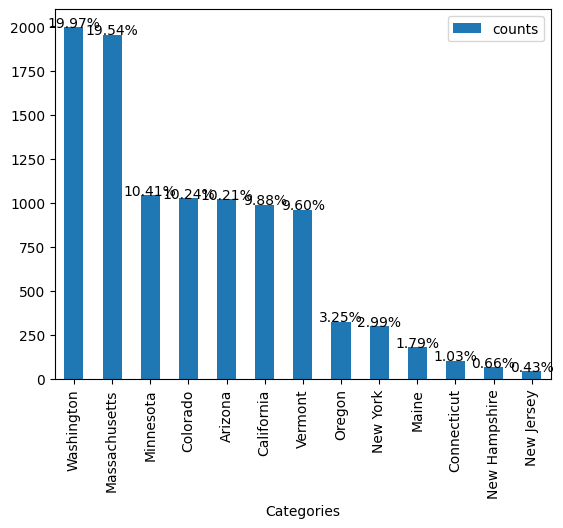

In [17]:
describe_categorical(df['state__c']) 

Number of Unique Categories : 12
    Categories  counts      %
0         12.0    1429  14.29
1         11.0    1351  13.51
2          9.0    1005  10.05
3          8.0     986   9.86
4          5.0     856   8.56
5         10.0     826   8.26
6          6.0     808   8.08
7          7.0     795   7.95
8          4.0     766   7.66
9          2.0     399   3.99
10         3.0     397   3.97
11         1.0     382   3.82


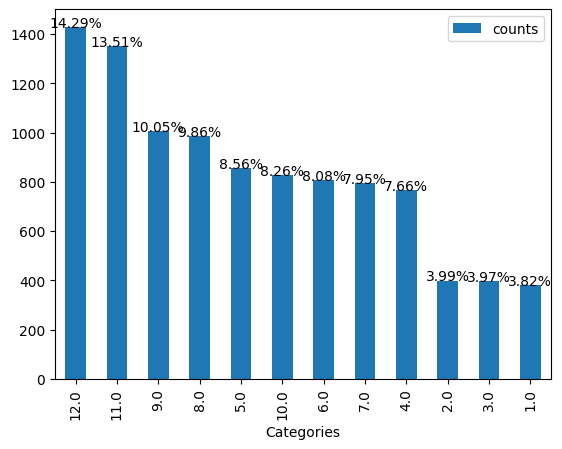

In [18]:
describe_categorical(df['month__c']) 

Number of Unique Categories : 2
   Categories  counts      %
0         0.0    8961  89.61
1         1.0    1039  10.39


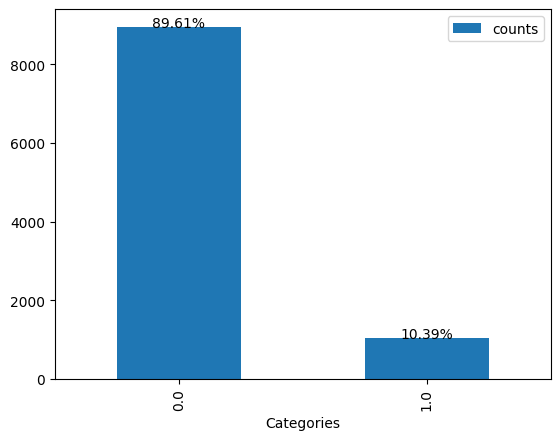

In [19]:
describe_categorical(df['case_type_return__c']) 

Number of Unique Categories : 2
   Categories  counts      %
0         0.0    9505  95.05
1         1.0     495   4.95


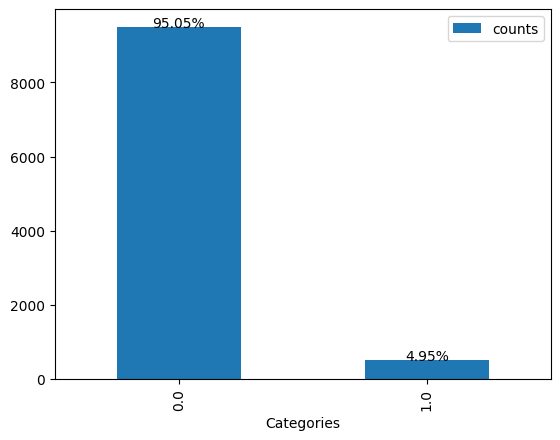

In [20]:
describe_categorical(df['case_type_shipment_damaged__c']) 

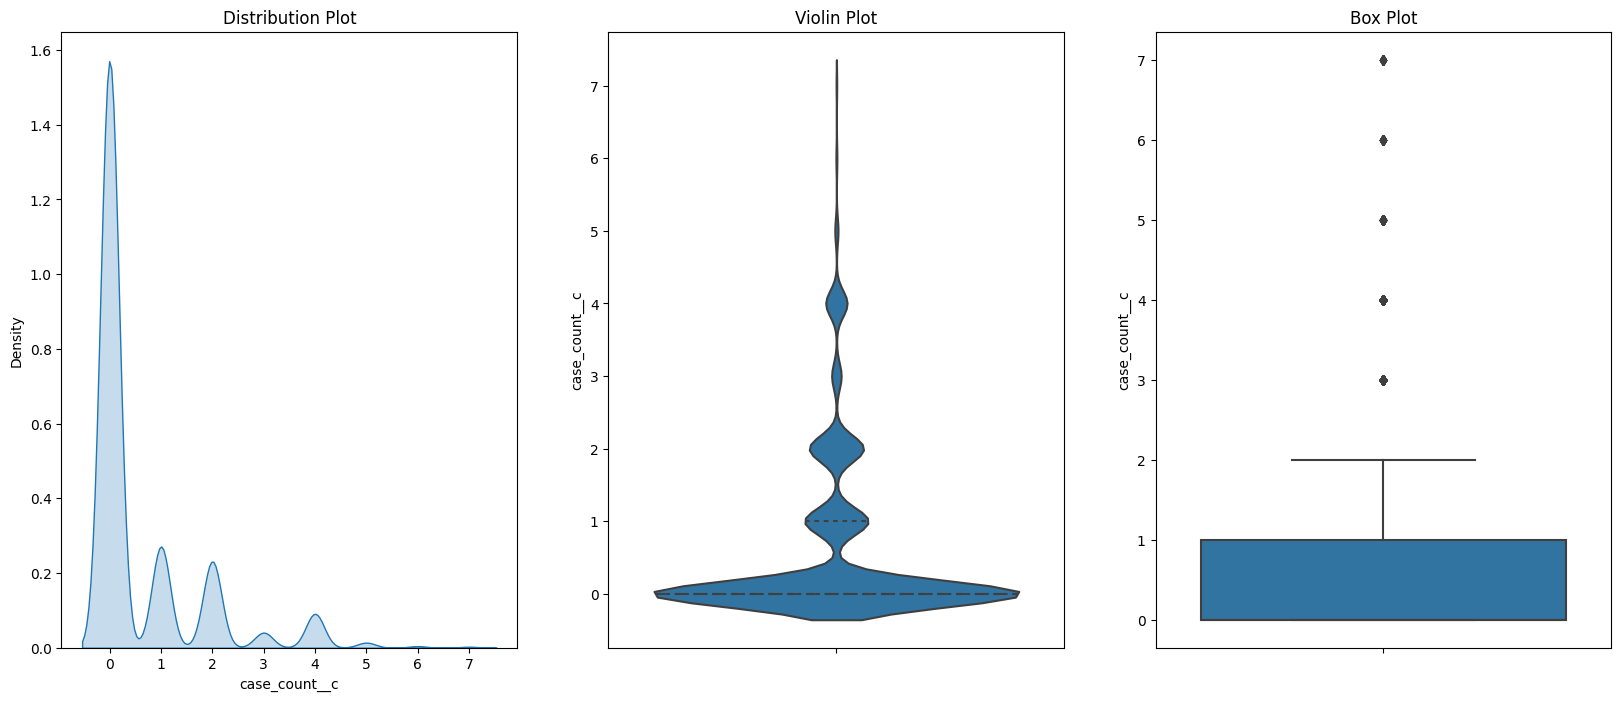

In [21]:
describe_continuous(df['case_count__c']) 

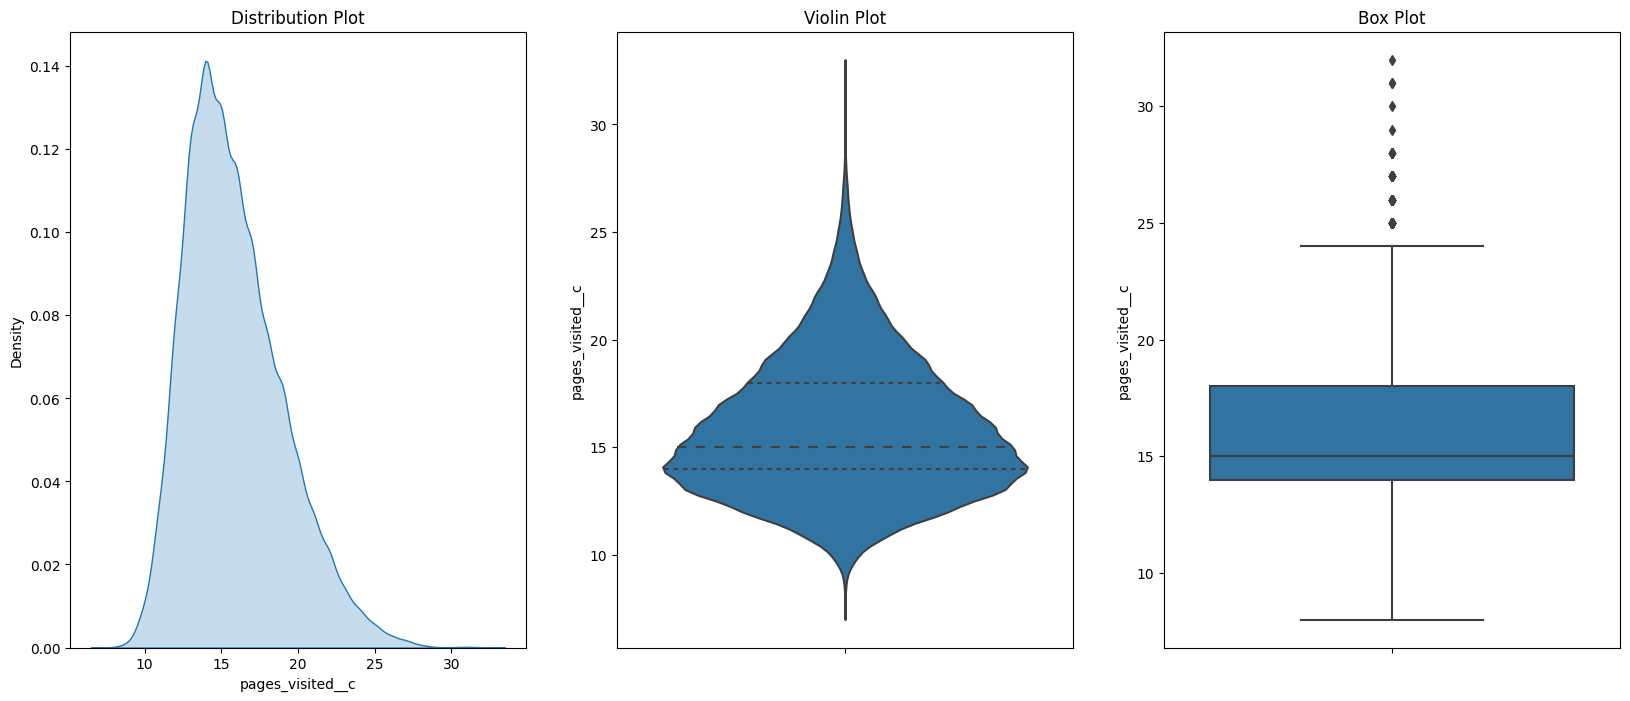

In [22]:
describe_continuous(df['pages_visited__c']) 

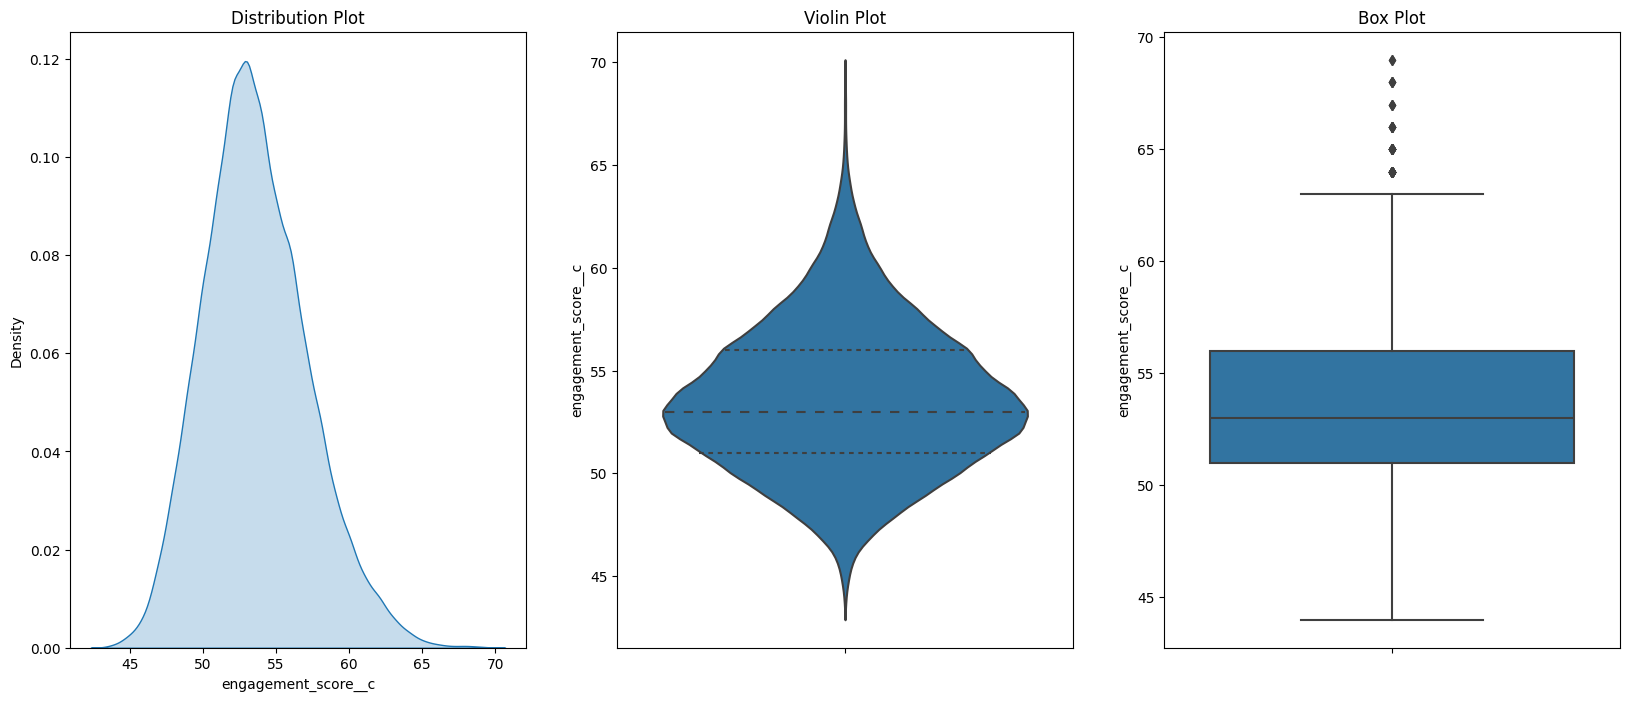

In [23]:
describe_continuous(df['engagement_score__c']) 

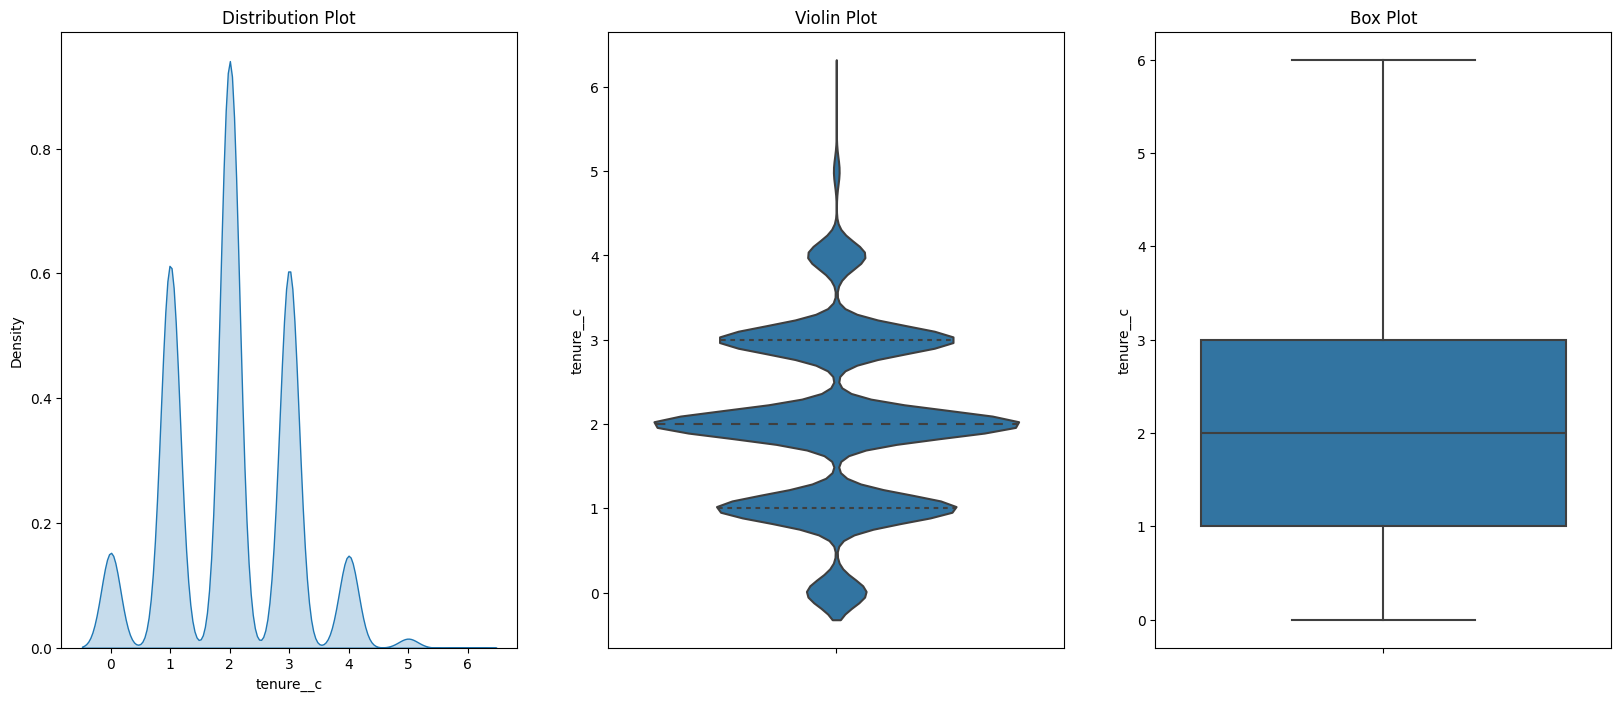

In [24]:
describe_continuous(df['tenure__c']) 

In [25]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


In [26]:
cat_columns = ['state__c', 'campaign__c', 'product_purchased__c']

In [27]:
#convert all categorical variables to numeric
df_Dummies =  pd.get_dummies(df , columns = cat_columns, drop_first = True)

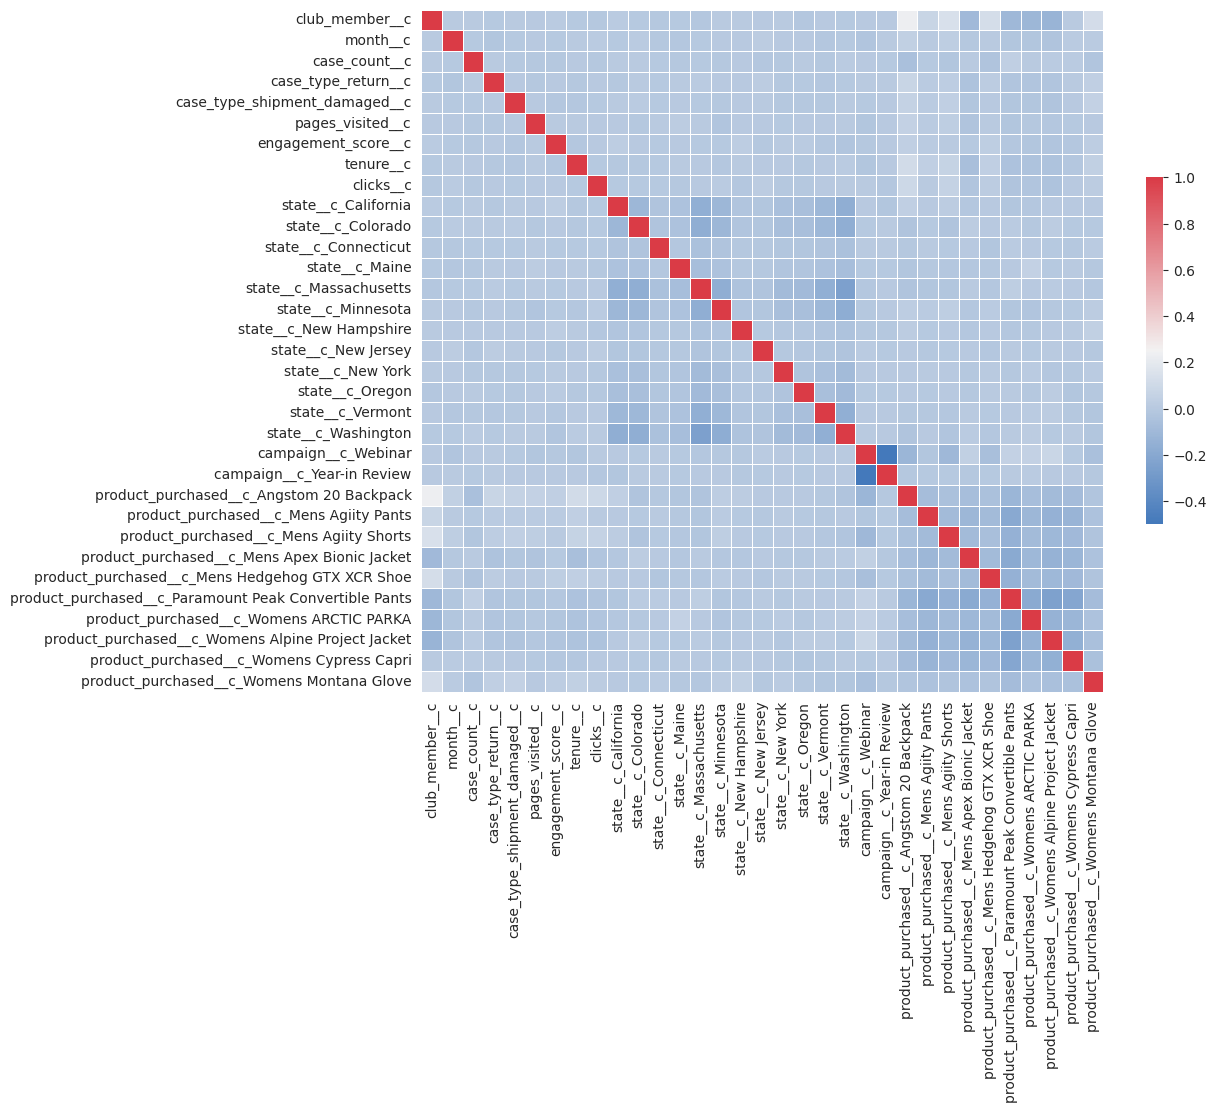

In [28]:
CorrMtx(df_Dummies.corr(), dropDuplicates = False)

In [29]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_Dummies, 5))

Top Absolute Correlations
campaign__c_Webinar                                    campaign__c_Year-in Review                           0.497068
state__c_Massachusetts                                 state__c_Washington                                  0.246170
product_purchased__c_Paramount Peak Convertible Pants  product_purchased__c_Womens Alpine Project Jacket    0.242950
club_member__c                                         product_purchased__c_Angstom 20 Backpack             0.228641
product_purchased__c_Paramount Peak Convertible Pants  product_purchased__c_Womens Cypress Capri            0.214222
dtype: float64


The correlation between predictors is not found to be significant so we do have to drop any predictors

Based on the exploratory data analysis the following transformations need to be made -  

1. Remove null records
2. Since the products purchased have a class imbalance we will need to balance the classes to reduce bias
3. Since club member is a binary predictor treat it as categorical
4. Since purchases in some states are much greater than others the states with smaller % of customers should be combined as other
5. Month is should be treated as categorical
6. Case counts greater than 3 can be combined into a single category
7. Since Case Type Return is a binary predictor treat it as categorical
8. Since Case Type Shipment Damaged is a binary predictor treat it as categorical
9. Engagement score and Clicks need to be scaled
10. Tenure needs to be treated as categorical and greater than 3 years can be combined into one bucket. 

In [30]:
# Remove null records
df.dropna(inplace=True)

In [31]:
# Separate features and target variable
X = df.drop("product_purchased__c", axis=1)
y = df["product_purchased__c"]

In [32]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [33]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [34]:
States_List = ['Washington', 'Massachusetts', 'California', 'Minnesota', 'Vermont', 'Colorado', 'Arizona']

In [35]:
# Apply custom transforms here

def transform(X):
    # Convert predictor types
    X['club_member__c'] = X['club_member__c'].astype(object)
    X['month__c'] = X['month__c'].astype(object)
    X['case_type_return__c'] = X['case_type_return__c'].astype(object)
    X['case_type_shipment_damaged__c'] = X['case_type_shipment_damaged__c'].astype(object) 
    # Implement your custom formula with if statement
    # For example, if you want to create a new column based on a condition:
    X['transformed_state__c'] = X['state__c'].apply(lambda x: 'Other' if x not in States_List else x) 
    X['transformed_cases__c'] = X['case_count__c'].apply(lambda x: 'No Cases' if x == 0 else '1 to 2 Cases' if x <= 2 else 'Greater than 2 Cases') 
    X['transformed_tenure__c'] = X['tenure__c'].apply(lambda x: 'Less than 1' if x < 1 else '1 to 2 Years' if x == 1 else '1 to 2 Years' if x == 2 else '2 to 3 Years' if x == 3 else 'Greater than 3 Years') 
    X = X.drop(['state__c', 'case_count__c', 'tenure__c'], axis=1)
    X = X.rename(columns={'transformed_state__c': 'state__c', 'transformed_cases__c': 'case_count__c', 'transformed_tenure__c': 'tenure__c'})
    return X 

X_train = transform(X_train)
X_test = transform(X_test)

In [36]:
numeric_features = ['engagement_score__c', 'clicks__c', 'pages_visited__c']
categorical_features = ['club_member__c', 
                        'campaign__c', 
                        'state__c', 
                        'month__c', 
                        'case_count__c', 
                        'case_type_return__c', 
                        'case_type_shipment_damaged__c', 'tenure__c']

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(), categorical_features)
    ])

In [38]:
# Define the KNN classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax')

In [39]:
# Define the hyperparameters to tune
param_grid = {
    'classifier__n_estimators': np.arange(100, 1001, 100),
    'classifier__max_depth': np.arange(3, 9, 4),
    'classifier__learning_rate': np.logspace(-2, 0, 3),
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': np.linspace(0, 0.2, 3),  # Range from 0 to 0.2 (inclusive) with 3 values
    'classifier__reg_alpha': np.linspace(0, 1.0, 3),  # Range from 0 to 1 (inclusive) with 3 values
    'classifier__reg_lambda': np.linspace(0, 1.0, 3),
}

In [40]:
# Create the ML pipeline
pipeline = Pipeline(steps=[
    ('transformer', preprocessor),
    ('classifier', xgb_classifier)
])

In [41]:
# Perform grid search for hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_grid, cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               StandardScaler(),
                                                                               ['engagement_score__c',
                                                                                'clicks__c',
                                                                                'pages_visited__c']),
                                                                              ('categorical',
                                                                               OneHotEncoder(),
                                                                               ['club_member__c',
                                                                                'campaign__c',
                                                                                'state__c',
                                                                                'month__c',
                                                                                'case_count__c',
                                                                                'case_type_return__c',
                                                                                'case_type_shipment_damaged__c',
                                                                                'tenure__c'])]...
                   param_distributions={'classifier__colsample_bytree': [0.8,
                                                                         1.0],
                                        'classifier__gamma': array([0. , 0.1, 0.2]),
                                        'classifier__learning_rate': array([0.01, 0.1 , 1.  ]),
                                        'classifier__max_depth': array([3, 7]),
                                        'classifier__n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'classifier__reg_alpha': array([0. , 0.5, 1. ]),
                                        'classifier__reg_lambda': array([0. , 0.5, 1. ]),
                                        'classifier__subsample': [0.8, 1.0]})

In [42]:
# Get the best hyperparameters and the corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [43]:
best_params

{'classifier__subsample': 0.8,
 'classifier__reg_lambda': 0.5,
 'classifier__reg_alpha': 0.5,
 'classifier__n_estimators': 500,
 'classifier__max_depth': 7,
 'classifier__learning_rate': 0.01,
 'classifier__gamma': 0.2,
 'classifier__colsample_bytree': 0.8}

In [44]:
best_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['engagement_score__c',
                                                   'clicks__c',
                                                   'pages_visited__c']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['club_member__c',
                                                   'campaign__c', 'state__c',
                                                   'month__c', 'case_count__c',
                                                   'case_type_return__c',
                                                   'case_type_shipment_damaged__c',
                                                   'tenure__c'])])),
                ('classifier',
                 XGBClassifier(bas...
                               feature_types=None, gamma=0.2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [45]:
y_pred = best_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get TP, FP, and TN counts for each class
TP = cm.diagonal()
FP = cm.sum(axis=0) - TP

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print TP, FP, and accuracy for each class
for i in range(len(TP)):
    print(f"Class {i}: TP={TP[i]}, FP={FP[i]}, Accuracy={TP[i] / (TP[i] + FP[i])}")

# Overall accuracy
print(f"Overall Accuracy: {accuracy}")

Class 0: TP=0, FP=0, Accuracy=nan
Class 1: TP=46, FP=33, Accuracy=0.5822784810126582
Class 2: TP=36, FP=108, Accuracy=0.25
Class 3: TP=42, FP=75, Accuracy=0.358974358974359
Class 4: TP=0, FP=10, Accuracy=0.0
Class 5: TP=18, FP=42, Accuracy=0.3
Class 6: TP=390, FP=966, Accuracy=0.28761061946902655
Class 7: TP=3, FP=13, Accuracy=0.1875
Class 8: TP=42, FP=130, Accuracy=0.2441860465116279
Class 9: TP=12, FP=29, Accuracy=0.2926829268292683
Class 10: TP=1, FP=4, Accuracy=0.2
Overall Accuracy: 0.295


Test the model

In [46]:
X_data = {
    'club_member__c': [0, 0, 0, 1],
    'campaign__c': ['Year-in Review', 'Year-in Review', 'New Colors', 'Year-in Review'],
    'state__c': ['Vermont', 'Vermont', 'Vermont', 'California'],
    'month__c': [11, 9, 11, 3],
    'case_count__c': [1, 2, 1, 2],
    'case_type_return__c': [1, 1, 1, 1],
    'case_type_shipment_damaged__c': [0, 1, 0, 0],
    'pages_visited__c': [22, 15, 15, 13],
    'engagement_score__c': [51, 54, 51, 51],
    'tenure__c': [3, 3, 4, 2],
    'clicks__c': [27, 21, 34, 27]
}

In [47]:
X_to_predict = transform(pd.DataFrame(X_data))

In [48]:
predictions = best_model.predict(X_to_predict)

In [49]:
predictions

array([6, 6, 6, 2], dtype=int32)

In [50]:
y_predicted = label_encoder.inverse_transform(predictions)

In [51]:
y_predicted

array(['Paramount Peak Convertible Pants',
       'Paramount Peak Convertible Pants',
       'Paramount Peak Convertible Pants', 'Mens Agiity Pants'],
      dtype=object)

Save the model artifacts

In [52]:
model_artifact_filename = 'model_artifacts/model.joblib'
encoder_filename = 'model_artifacts/labelencoder.joblib'

In [53]:
# Save model artifact to local filesystem (doesn't persist)
joblib.dump(best_model, model_artifact_filename)
joblib.dump(label_encoder, encoder_filename)

['model_artifacts/labelencoder.joblib']